In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import functions_data_processing as fsd
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from itertools import combinations
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier

In [2]:
# This cell changes the values of the df.csv file in order for the absent state to have a value of 0 instead of 0.1 and the present state to have a value of 1 instead of 0.9
# Furthermore it adds a new column in which we have both values of Microwave and Default combined

df_imported = pd.read_csv('df.csv', index_col=0)
df_imported = df_imported
df_imported.index = pd.to_datetime(df_imported.index)
df = pd.DataFrame()
df['Microwave'] = df_imported['Microwave']
df['Default'] = df_imported['Default']
df['Ground Truth'] = df_imported['Ground Truth']
df['Microwave - Default (combined)'] = 'temporary'
df['Garage door'] = df_imported['Garage door']

df =df.mask(df==0.9, 1)
df =df.mask(df==0.1, 0)

mask1 = (df['Microwave']==1.0) & (df['Default']==1.0)
mask2 = (df['Microwave']==0.0) & (df['Default']==1.0)
mask3 = (df['Microwave']==0.0) & (df['Default']==0.0)
mask4 = (df['Microwave']==1.0) & (df['Default']==0.0)

df['Microwave - Default (combined)'] = ''
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask1, '11')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask2, '01')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask3, '00')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask4, '10')
df.iloc[8640:10080]


,Microwave,Default,Ground Truth,Microwave - Default (combined),Garage door
2016-01-07 05:00:00,0.0,1.0,1.0,01,0.0
2016-01-07 05:01:00,0.0,1.0,1.0,01,0.0
2016-01-07 05:02:00,0.0,1.0,1.0,01,0.0
2016-01-07 05:03:00,0.0,1.0,1.0,01,0.0
2016-01-07 05:04:00,0.0,1.0,1.0,01,0.0
...,...,...,...,...,...
2016-01-08 04:55:00,0.0,1.0,1.0,01,0.0
2016-01-08 04:56:00,0.0,1.0,1.0,01,0.0
2016-01-08 04:57:00,0.0,1.0,1.0,01,0.0
2016-01-08 04:58:00,0.0,1.0,1.0,01,0.0


<AxesSubplot: ylabel='Default'>

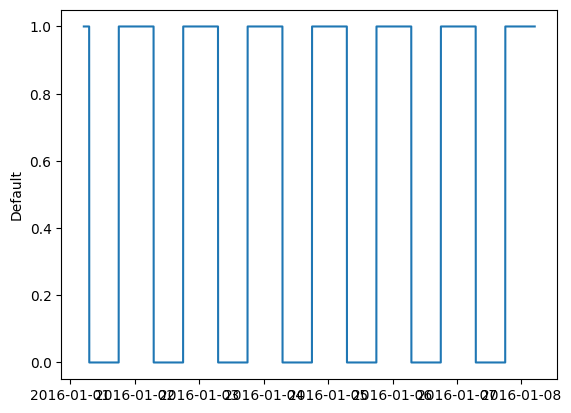

In [3]:


sns.lineplot(df['Default'].iloc[:10080])

In [4]:
# A function that selects a section of the data frame based on a starting date and interval

def interval_model(data_frame, starting_date, interval):
    
    s_date = pd.to_datetime(starting_date, format='%Y-%m-%d %H:%M:%S.%f')
    data_frame = data_frame.loc[s_date : s_date + interval]
    return data_frame
   

In [5]:
# An example of using the function interval_model defined above
df_model = df['Microwave - Default (combined)']

df_model = interval_model(data_frame= df_model, starting_date='2016-02-01 05:00:00', interval=datetime.timedelta(days=7))

df_model.iloc[:]

2016-02-01 05:00:00    01
2016-02-01 05:01:00    01
2016-02-01 05:02:00    01
2016-02-01 05:03:00    01
2016-02-01 05:04:00    01
                       ..
2016-02-08 04:56:00    01
2016-02-08 04:57:00    01
2016-02-08 04:58:00    01
2016-02-08 04:59:00    01
2016-02-08 05:00:00    01
Name: Microwave - Default (combined), Length: 10081, dtype: object

In [6]:
def plot_dfs(data_frame, attributes, graphing_interval):
    start_date = pd.to_datetime(graphing_interval[0])
    end_date = pd.to_datetime(graphing_interval[1])

    sliced_df = data_frame.loc[start_date:end_date, attributes]

    sns.lineplot(data=sliced_df)
    plt.xlabel('Time')
    plt.ylabel('Attribute')
    plt.title('Plot of Attributes')
    plt.show()

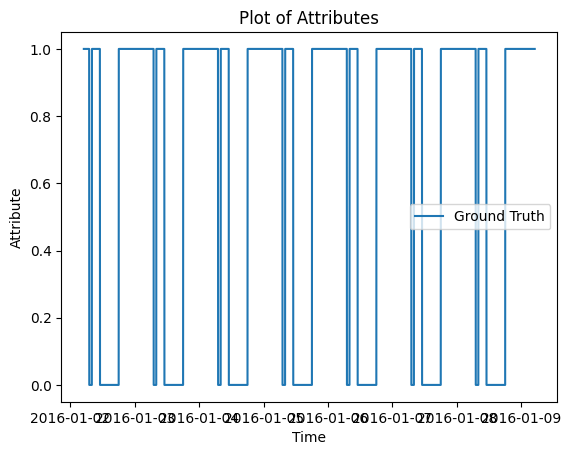

In [7]:
#time = range(len(state_ests))
#ests_df = pd.DataFrame(data=state_ests[:500], index=df.index[:500], columns=['Presence'])
#g = sns.lineplot(data=ests_df).set(title='Estimated presence')
plot_dfs(df, ['Ground Truth'], ['2016-01-02 05:00:00', '2016-01-09 05:00:00'])

Random cross validation

In [8]:
#Markov Chain - 2 (without aggregation) - random cross validation

'''
y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))
ss = ShuffleSplit(n_splits=10, test_size=0.3)

y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.5, 0.5])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.2, 0.3, 0.25],
                           [0.25, 0.25, 0.25, 0.25]])

# Transition matrix of hidden states
trans_mat = np.array([[0.5, 0.5], [0.5, 0.5]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])



# Build the model
# Set up model:
model_2 = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='')

model_2.n_features = len(o_states)


model_2.startprob_ = start_probs
model_2.transmat_ = trans_mat
model_2.emissionprob_ = emission_probs




x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))



for split_number, (train_index, test_index) in enumerate(ss.split(x, y)):
    
    print("Split:", split_number)

    #print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)
    
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train:", train_index)
    print("Test", test_index)

    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model_2.fit(X_train)
    logprob, state_ests = model_2.decode(X_test)

    y_pred_proba = state_ests

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

    

    print("Learned emission probs:")
    print(model_2.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model_2.transmat_)

    

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

'''

'\ny_true_original = interval_model(data_frame= df[\'Ground Truth\'], starting_date=\'2016-01-01 05:00:00\', interval=datetime.timedelta(days=7))\nss = ShuffleSplit(n_splits=10, test_size=0.3)\n\ny_true_all = []\n\ndef sequence2counts(status, ostates2id):\n    ans = []\n    for word, idx in ostates2id.items():\n       \n        count = status.count(word)\n        ans.append(count)\n    return ans\n\n\n# Smart home situation states: hidden state\nh_states = [\'absent\', \'present\'] # not at home, at home\nid2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words\n\n# Initial distribution of hidden states\nstart_probs = np.array([0.5, 0.5])\n\n# microwave and GT: observable states: \n# Pos 1: Default $Df$\n# Pos 2: Microvave on off\no_states = [\'00\', \'01\', \'10\', \'11\']  \nid2ostates = dict(zip(o_states, range(len(o_states))))\n\n# Transition probs from hidden to observable states\nemission_probs = np.array([[0.25, 0.2, 0.3, 0.25],\n                      

Daily cross validation

In [9]:
#Markov Chain - 2 (without aggregation) - specific cross validation

'''

y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))


y_true_all_2 = []

y_pred_proba_all_2 = []
y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.5, 0.5])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Transition matrix of hidden states
trans_mat = np.array([[0.95, 0.05], [0.05, 0.95]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])


print(data[0])


# Build the model
# Set up model:
model = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='',)

model.n_features = len(o_states)

model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs




x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))


print(x.shape)
train_days = 5
test_days = 2

# Calculate the total number of minutes in the data
total_minutes = len(x)

day = 24*60
n_splits = 5


random_numbers = random.sample(list(range(1,8)), 5)

not_included = [num for num in list(range(1,8)) if num not in random_numbers]

print(random_numbers)
print(not_included)

for n in range(n_splits):
    print(n)


    start = random_numbers[0]
    X_train = x[(start-1)*day:start*day]
    y_train = y[(start-1)*day:start*day]

    start_not = not_included[0]
    X_test = x[(start_not-1)*day:start_not*day]
    y_test = y[(start_not-1)*day:start_not*day]


    # Perform the train-test split
    for i in random_numbers[1:]:
        X_train = np.vstack((X_train, x[(i-1)*day:i*day]))
        y_train = np.vstack((y_train, y[(i-1)*day:i*day]))

    for i in not_included[1:]:
        X_test = np.vstack((X_test, x[(i-1)*day:i*day]))
        y_test = np.vstack((y_test, y[(i-1)*day:i*day]))

    # Convert the data to the desired type
    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model.fit(X_train)
    logprob, state_ests = model.decode(X_test)

    y_pred_proba = state_ests

    print(state_ests)
    print(y_test)


    # Compute ROC curve and AUC score
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(np.ravel(y_test), y_pred_proba)

    auc_score = roc_auc_score(np.ravel(y_test), y_pred_proba)


    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(n, round(auc_score, 2)))

    # Print confusion matrix
    y_pred = np.round(y_pred_proba)
    print(confusion_matrix(np.ravel(y_test), np.ravel(y_pred)))

    print("Learned emission probs:")
    print(model.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model.transmat_)




# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

'''

'\n\ny_true_original = interval_model(data_frame= df[\'Ground Truth\'], starting_date=\'2016-01-01 05:00:00\', interval=datetime.timedelta(days=7))\n\n\ny_true_all_2 = []\n\ny_pred_proba_all_2 = []\ny_true_all = []\n\ndef sequence2counts(status, ostates2id):\n    ans = []\n    for word, idx in ostates2id.items():\n       \n        count = status.count(word)\n        ans.append(count)\n    return ans\n\n\n# Smart home situation states: hidden state\nh_states = [\'absent\', \'present\'] # not at home, at home\nid2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words\n\n# Initial distribution of hidden states\nstart_probs = np.array([0.5, 0.5])\n\n# microwave and GT: observable states: \n# Pos 1: Default $Df$\n# Pos 2: Microvave on off\no_states = [\'00\', \'01\', \'10\', \'11\']  \nid2ostates = dict(zip(o_states, range(len(o_states))))\n\n# Transition probs from hidden to observable states\nemission_probs = np.array([[0.25, 0.1, 0.4, 0.25],\n                   

Cross validation -> Train on Monday and test the next Monday 


Same day / Between days cross validation

In [10]:

#Markov Chain - 2 (without aggregation) - specific cross validation

'''
df_model_2 = interval_model(data_frame= df['Microwave - Default (combined)'], starting_date='2016-01-25 05:00:00', interval=datetime.timedelta(days=21))
y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-25 05:00:00', interval=datetime.timedelta(days=21))


y_true_all_2 = []

y_pred_proba_all_2 = []
y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.8, 0.2])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.2, 0.3, 0.25],
                           [0.3, 0.3, 0.2, 0.1]])

# Transition matrix of hidden states
trans_mat = np.array([[0.2, 0.8], [0.7, 0.3]])

observations = df_model_2.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)

n_trials = len(observations[0])

print(n_trials)
# Build the model
# Set up model:
model_new = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='ste', params= 'ste')

model_new.n_features = len(o_states)



#model_new.startprob_ = start_probs
#model_new.transmat_ = trans_mat
#model_new.emissionprob_ = emission_probs



x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))


# Calculate the total number of minutes in the data
total_minutes = len(x)

day = 24*60

np.set_printoptions(threshold=np.inf)

for fold in range(7):

    
    print("Fold: ", fold)

    
    #print("Start probabilities:")
    #print(model.startprob_)

    #print("Emission probabilities:")
    #print(model.emissionprob_)

    #print("Transition probabilities:")
    #print(model.transmat_)
    
    


    # Training data (first 24 hours)
    start_train = fold
    end_train = start_train + 1
    X_train = x[start_train * day :end_train * day]
    y_train = y[start_train * day :end_train * day]

    # Testing data (a week later)
    start_test = 8 + start_train
    end_test = start_test + 1
    X_test = x[start_test * day :end_test  * day]
    y_test = y[start_test * day :end_test  * day]

    
    #if fold == 0:
     #   model.startprob_ = [0.5, 0.5]
    #else:
     #   model.startprob_ = [0.9, 0.1]
    
    
    
    #print(y_test.shape)
    #print(X_test.shape)
    #print(X_test)
    

    
    # Convert the data to the desired type
    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model_new.fit(X_train)
    logprob, state_ests = model_new.decode(X_test)
    y_pred_proba = state_ests

    print("logprob: ", logprob)
    #print("state_ests: ", state_ests)


    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(fold, round(auc_score, 2)))

    # Print confusion matrix
    y_pred = np.round(y_pred_proba)
    print(confusion_matrix(np.ravel(y_test), np.ravel(y_pred)))

    print("Learned emission probs:")
    print(model_new.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model_new.transmat_)

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

'''


'\ndf_model_2 = interval_model(data_frame= df[\'Microwave - Default (combined)\'], starting_date=\'2016-01-25 05:00:00\', interval=datetime.timedelta(days=21))\ny_true_original = interval_model(data_frame= df[\'Ground Truth\'], starting_date=\'2016-01-25 05:00:00\', interval=datetime.timedelta(days=21))\n\n\ny_true_all_2 = []\n\ny_pred_proba_all_2 = []\ny_true_all = []\n\ndef sequence2counts(status, ostates2id):\n    ans = []\n    for word, idx in ostates2id.items():\n       \n        count = status.count(word)\n        ans.append(count)\n    return ans\n\n\n# Smart home situation states: hidden state\nh_states = [\'absent\', \'present\'] # not at home, at home\nid2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words\n\n# Initial distribution of hidden states\nstart_probs = np.array([0.8, 0.2])\n\n# microwave and GT: observable states: \n# Pos 1: Default $Df$\n# Pos 2: Microvave on off\no_states = [\'00\', \'01\', \'10\', \'11\']  \nid2ostates = dict(zip(o_s

StratifiedKFold validation 

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Trials  2
Split: 0
X train:  [0.45625    0.54016204 0.00104167 0.0025463 ]
Y train:  [0.5 0.5]
X test:  [0.46426093 0.53088133 0.         0.00485774]
Y test:  [0.5 0.5]
[[  0 480]
 [  0 961]]
Learned emission probs:
[[0.25 0.2  0.3  0.25]
 [0.25 0.25 0.25 0.25]]
Learned transition matrix:
[[0.5 0.5]
 [0.5 0.5]]
------------------------------------
Split: 1
X train:  [0.45758593 0.53847934 0.00081009 0.00312464]
Y train:  [0.5 0.5]
X test:  [0.45625    0.54097222 0.00138889 0.00138889]
Y test:  [0.5 0.5]
[[  2 478]
 [  0 960]]
Learned emission probs:
[[0.25 0.2  0.3  0.25]
 [0.25 0.25 0.25 0.25]]
Learned transition matrix:
[[0.5 0.5]
 [0.5 0.5]]
------------------------------------
Split: 2
X train:  [0.4587432  0.53813216 0.00057864 0.002546  ]
Y train:  [0.5 0.5]
X test:  [0.44930556 0.54305556 0.00277778 0.00486111]
Y test:  [0.5 0.5]
[[  4 476]
 [  0 960]]
Learned emission probs:
[[0.25 0.2  0.3  0.25]
 [0.25 0.25 0.25 0.25]]
Learned transition matrix:
[[0.5 0.5]
 [0.5 0.5]]
-------

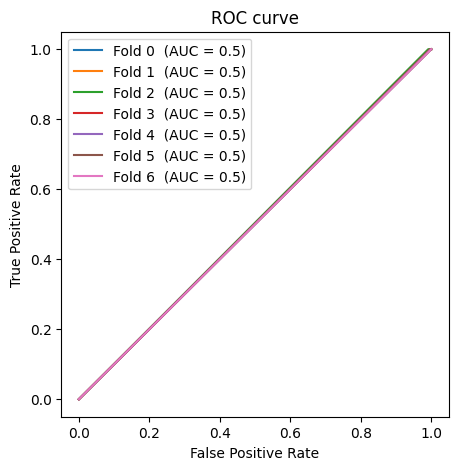

In [11]:
y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))
ss = ShuffleSplit(n_splits=7, test_size=0.3)

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=2)

y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.5, 0.5])

# microwave and GT: observable states:
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.2, 0.3, 0.25], [0.25, 0.25, 0.25, 0.25]])

# Transition matrix of hidden states
trans_mat = np.array([[0.5, 0.5], [0.5, 0.5]])


'''
emission_probs = np.array([[0.35, 0.15, 0.4, 0.1],
                           [0.15, 0.35, 0.25, 0.25]])

# Transition matrix of hidden states
trans_mat = np.array([[0.5, 0.5], [0.5, 0.5]])

'''

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)



n_trials = len(observations[0])
print("Trials ", n_trials)

# Build the model
# Set up model:
model_2 = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='', params='')

model_2.n_features = len(o_states)


#model_2.startprob_ = start_probs
model_2.transmat_ = trans_mat
model_2.emissionprob_ = emission_probs


x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))


for split_number, (train_index, test_index) in enumerate(skf.split(x, y)):

    print("Split:", split_number)
    #print("Starting probs: ", model_2.startprob_)

    # print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)

    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = X_train.astype(int)

    counter_Xtrain = [0, 0, 0, 0]
    for i in X_train:
        if i[0] == 1:
            counter_Xtrain[0] = counter_Xtrain[0] + 1
        if i[1] == 1:
            counter_Xtrain[1] = counter_Xtrain[1] + 1
        if i[2] == 1:
            counter_Xtrain[2] = counter_Xtrain[2] + 1
        if i[3] == 1:
            counter_Xtrain[3] = counter_Xtrain[3] + 1

    print("X train: ", counter_Xtrain/np.sum(counter_Xtrain))

    counter_ytrain = [0, 0]
    for i in y_train:
        if i == 1:
            counter_ytrain[0] = counter_ytrain[0] + 1
        if i == 1:
            counter_ytrain[1] = counter_ytrain[1] + 1

    print("Y train: ", counter_ytrain / np.sum(counter_ytrain))

    counter_Xtest = [0, 0, 0, 0]
    for i in X_test:
        if i[0] == 1:
            counter_Xtest[0] = counter_Xtest[0] + 1
        if i[1] == 1:
            counter_Xtest[1] = counter_Xtest[1] + 1
        if i[2] == 1:
            counter_Xtest[2] = counter_Xtest[2] + 1
        if i[3] == 1:
            counter_Xtest[3] = counter_Xtest[3] + 1

    print("X test: ", counter_Xtest / np.sum(counter_Xtest))

    counter_ytest = [0, 0]
    for i in y_test:
        if i == 1:
            counter_ytest[0] = counter_ytest[0] + 1
        if i == 1:
            counter_ytest[1] = counter_ytest[1] + 1

    print("Y test: ", counter_ytest / np.sum(counter_ytest))

    # Fit the model and predict probabilities for the test set
    model_2.fit(X_train)
    logprob, state_ests = model_2.decode(X_test)

    y_pred_proba = state_ests

    # Fit the model and predict probabilities for the test set
    model_2.fit(X_train)
    logprob, state_ests = model_2.decode(X_test)

    y_pred_proba = state_ests

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

    print("Learned emission probs:")
    print(model_2.emissionprob_)

    print("Learned transition matrix:")
    print(model_2.transmat_)
    print("------------------------------------")

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [12]:
# Graph of input before oversampling
#plot_dfs(df, 'Microwave - Default (combined)', [y_true_original.index[0], y_true_original.index[-1]])

In [13]:
# Histogram 

'''
data = df['Microwave - Default (combined)'].loc[y_true_original.index[0]:y_true_original.index[-1]]
fig, ax = plt.subplots()
sns.histplot(data, ax=ax, stat='probability', discrete=True)
plt.xlabel('Categories')
plt.ylabel('Probability')
plt.show()

'''


"\ndata = df['Microwave - Default (combined)'].loc[y_true_original.index[0]:y_true_original.index[-1]]\nfig, ax = plt.subplots()\nsns.histplot(data, ax=ax, stat='probability', discrete=True)\nplt.xlabel('Categories')\nplt.ylabel('Probability')\nplt.show()\n\n"

In [14]:
# This is how the oversampling is performed

'''
i = 0
while i < 10080:
    if df['Microwave - Default (combined)'].iloc[i] == '11':
        df.loc[i:i+170, 'Microwave - Default (combined)'] = '11'
        i += 200
    if df['Microwave - Default (combined)'].iloc[i] == '10':
        df.loc[i:i+250, 'Microwave - Default (combined)'] = '10'
        i += 270
    else:
        i += 1

'''

"\ni = 0\nwhile i < 10080:\n    if df['Microwave - Default (combined)'].iloc[i] == '11':\n        df.loc[i:i+170, 'Microwave - Default (combined)'] = '11'\n        i += 200\n    if df['Microwave - Default (combined)'].iloc[i] == '10':\n        df.loc[i:i+250, 'Microwave - Default (combined)'] = '10'\n        i += 270\n    else:\n        i += 1\n\n"

In [15]:
# Histogram after oversampling
#sns.histplot(df['Microwave - Default (combined)'].loc[y_true_original.index[0] :  y_true_original.index[-1]])

In [16]:
# Graph of input after oversampling
#plot_dfs(df, 'Microwave - Default (combined)', [y_true_original.index[0], y_true_original.index[-1]])

StratifiedKFold validation after oversampling

In [17]:
'''

y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))
#ss = ShuffleSplit(n_splits=10, test_size=0.3)

y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.9, 0.1])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.2, 0.3, 0.25],
                           [0.25, 0.25, 0.25, 0.25]])

# Transition matrix of hidden states
trans_mat = np.array([[0.5, 0.5], [0.5, 0.5]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])



# Build the model
# Set up model:
model_2 = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='')

model_2.n_features = len(o_states)


model_2.startprob_ = start_probs
model_2.transmat_ = trans_mat
model_2.emissionprob_ = emission_probs

x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))



for split_number, (train_index, test_index) in enumerate(skf.split(x, y)):
    
    print("Split:", split_number)

    print("Starting prob: ", model.startprob_)

    #print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)
    
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train:", train_index)
    print("Test", test_index)

    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model_2.fit(X_train)
    logprob, state_ests = model_2.decode(X_test)

    y_pred_proba = state_ests

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

    

    print("Learned emission probs:")
    print(model_2.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model_2.transmat_)

    

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

'''

'\n\ny_true_original = interval_model(data_frame= df[\'Ground Truth\'], starting_date=\'2016-01-01 05:00:00\', interval=datetime.timedelta(days=7))\n#ss = ShuffleSplit(n_splits=10, test_size=0.3)\n\ny_true_all = []\n\ndef sequence2counts(status, ostates2id):\n    ans = []\n    for word, idx in ostates2id.items():\n       \n        count = status.count(word)\n        ans.append(count)\n    return ans\n\n\n# Smart home situation states: hidden state\nh_states = [\'absent\', \'present\'] # not at home, at home\nid2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words\n\n# Initial distribution of hidden states\nstart_probs = np.array([0.9, 0.1])\n\n# microwave and GT: observable states: \n# Pos 1: Default $Df$\n# Pos 2: Microvave on off\no_states = [\'00\', \'01\', \'10\', \'11\']  \nid2ostates = dict(zip(o_states, range(len(o_states))))\n\n# Transition probs from hidden to observable states\nemission_probs = np.array([[0.25, 0.2, 0.3, 0.25],\n                   

Random classifier

In [18]:
'''
class RandomClassifier:
    def fit(self, X, y=None):
        pass  # A random classifier doesn't need to fit to the data

    def predict(self, X):
        # Generate random predictions
        n_samples = X.shape[0]
        random_predictions = np.random.choice([0, 1], size=n_samples)
        return random_predictions

# Example usage
X_test = np.random.rand(10080, 2)  # Example test data with 100 samples and 5 features
random_classifier = RandomClassifier()
random_predictions = random_classifier.predict(X_test)

# Replace with your actual data loading code
# y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))

n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

x = X_test
y = np.random.choice([0, 1], size=len(x))  # Placeholder for example purposes

fig, ax = plt.subplots(figsize=(5, 5))

for split_number, (train_index, test_index) in enumerate(kf.split(x)):
    print("Split:", split_number)
    
    X_train, X_val = x[train_index], x[test_index]
    y_train, y_val = y[train_index], y[test_index]
    
    # Create a new random classifier for each split
    random_classifier = RandomClassifier()
    
    # Fit the model and predict probabilities for the validation set
    y_pred_proba = random_classifier.predict(X_val)
    
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    
    print(confusion_matrix(y_val, y_pred_proba))
    
    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score, 2)))

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

'''

'\nclass RandomClassifier:\n    def fit(self, X, y=None):\n        pass  # A random classifier doesn\'t need to fit to the data\n\n    def predict(self, X):\n        # Generate random predictions\n        n_samples = X.shape[0]\n        random_predictions = np.random.choice([0, 1], size=n_samples)\n        return random_predictions\n\n# Example usage\nX_test = np.random.rand(10080, 2)  # Example test data with 100 samples and 5 features\nrandom_classifier = RandomClassifier()\nrandom_predictions = random_classifier.predict(X_test)\n\n# Replace with your actual data loading code\n# y_true_original = interval_model(data_frame= df[\'Ground Truth\'], starting_date=\'2016-01-01 05:00:00\', interval=datetime.timedelta(days=7))\n\nn_splits = 7\nkf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n\nx = X_test\ny = np.random.choice([0, 1], size=len(x))  # Placeholder for example purposes\n\nfig, ax = plt.subplots(figsize=(5, 5))\n\nfor split_number, (train_index, test_index) in enumer

Majority classifier

In [19]:
'''
def fit(y):
    # Calculate the majority class
    return np.bincount(y).argmax()

y = np.zeros([10080,1])
y = df['Ground Truth'].iloc[:10080]


def predict(input):
    # Predict the majority class for all samples
    n_samples = input.shape[0]
    majority_predictions = np.full(n_samples, fit(input))
    return majority_predictions


total_indices = 10080

# Number of splits
num_splits = 7

# List to store the splits
all_splits = []

plt.figure(figsize=(8, 6))


for split_number in range(num_splits):

    print("Fold: ", split_number)

    indices_split = np.random.permutation(total_indices)
    all_splits.append(indices_split)
        
    fpr, tpr, _ = roc_curve(y[indices_split], predict(y[indices_split]))
    roc_auc = auc(fpr, tpr)

    print(confusion_matrix(y[indices_split], predict(y[indices_split])))
        
    plt.plot(fpr, tpr, lw=1, label=f'Fold {split_number} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

'''

'\ndef fit(y):\n    # Calculate the majority class\n    return np.bincount(y).argmax()\n\ny = np.zeros([10080,1])\ny = df[\'Ground Truth\'].iloc[:10080]\n\n\ndef predict(input):\n    # Predict the majority class for all samples\n    n_samples = input.shape[0]\n    majority_predictions = np.full(n_samples, fit(input))\n    return majority_predictions\n\n\ntotal_indices = 10080\n\n# Number of splits\nnum_splits = 7\n\n# List to store the splits\nall_splits = []\n\nplt.figure(figsize=(8, 6))\n\n\nfor split_number in range(num_splits):\n\n    print("Fold: ", split_number)\n\n    indices_split = np.random.permutation(total_indices)\n    all_splits.append(indices_split)\n        \n    fpr, tpr, _ = roc_curve(y[indices_split], predict(y[indices_split]))\n    roc_auc = auc(fpr, tpr)\n\n    print(confusion_matrix(y[indices_split], predict(y[indices_split])))\n        \n    plt.plot(fpr, tpr, lw=1, label=f\'Fold {split_number} (AUC = {roc_auc:.2f})\')\n\nplt.plot([0, 1], [0, 1], color=\'navy\', 

In [20]:
"""
X = np.array(df_model)

y = np.zeros([10081,1])
y = df['Ground Truth'].iloc[:10081]

dummy_clf = DummyClassifier(strategy="most_frequent")

# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=20)

# Lists to store AUC scores
auc_scores = []

for train_index, test_index in skf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

    dummy_clf.fit(X_train, y_train)
    y_pred_prob = dummy_clf.predict(X_test)  
    auc = roc_auc_score(y_test, y_pred_prob)
    auc_scores.append(auc)

# Print the AUC scores for each fold
for fold, auc in enumerate(auc_scores):
    print(f"Fold {fold + 1} AUC: {auc:.2f}")

# Calculate and print the mean AUC
mean_auc = np.mean(auc_scores)
print(f"Mean AUC: {mean_auc:.2f}")

"""

'\nX = np.array(df_model)\n\ny = np.zeros([10081,1])\ny = df[\'Ground Truth\'].iloc[:10081]\n\ndummy_clf = DummyClassifier(strategy="most_frequent")\n\n# Define the number of folds\nn_splits = 5\n\n# Initialize StratifiedKFold\nskf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=20)\n\n# Lists to store AUC scores\nauc_scores = []\n\nfor train_index, test_index in skf.split(X, y):\n\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n    \n\n    dummy_clf.fit(X_train, y_train)\n    y_pred_prob = dummy_clf.predict(X_test)  \n    auc = roc_auc_score(y_test, y_pred_prob)\n    auc_scores.append(auc)\n\n# Print the AUC scores for each fold\nfor fold, auc in enumerate(auc_scores):\n    print(f"Fold {fold + 1} AUC: {auc:.2f}")\n\n# Calculate and print the mean AUC\nmean_auc = np.mean(auc_scores)\nprint(f"Mean AUC: {mean_auc:.2f}")\n\n'

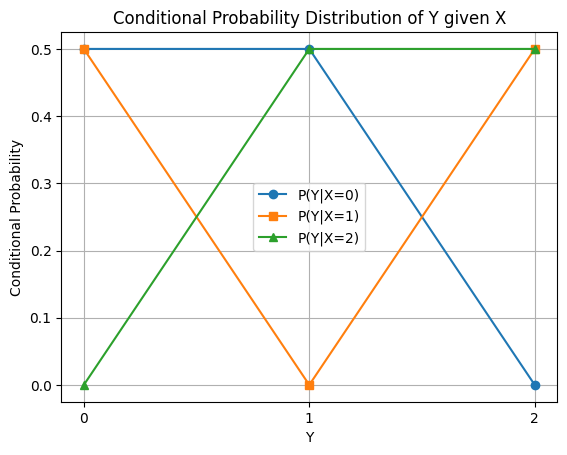

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
# Suppose you have two discrete random variables X and Y
# X represents the number of heads in two coin tosses
# Y represents the total number of heads and tails in two coin tosses
# Let's define their joint probability distribution as a 2D array
joint_prob = np.array([[0.25, 0.25, 0.0], [0.25, 0.0, 0.25], [0.0, 0.25, 0.25]])

# Define the conditional probability distribution of Y given X=0, X=1, and X=2
# P(Y|X=0), P(Y|X=1), P(Y|X=2)
# These are the rows of the joint probability distribution normalized by the sum along the columns
cond_prob_given_X0 = joint_prob[0] / np.sum(joint_prob[0])
cond_prob_given_X1 = joint_prob[1] / np.sum(joint_prob[1])
cond_prob_given_X2 = joint_prob[2] / np.sum(joint_prob[2])

# Plot the conditional probability distributions
x_values = [0, 1, 2]  # Possible values of X
plt.plot(x_values, cond_prob_given_X0, label="P(Y|X=0)", marker="o")
plt.plot(x_values, cond_prob_given_X1, label="P(Y|X=1)", marker="s")
plt.plot(x_values, cond_prob_given_X2, label="P(Y|X=2)", marker="^")

plt.xlabel("Y")
plt.ylabel("Conditional Probability")
plt.title("Conditional Probability Distribution of Y given X")
plt.xticks(x_values)
plt.legend()
plt.grid(True)
plt.show()